In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pandas as pd
import numpy as np
import scipy.stats  as stats
import seaborn as sns
import glob
import matplotlib.pyplot as plt
from quality.analyze_types import create_typed_predictions, get_entity_node_degrees, create_combined_df, create_combined_over_embeddings, _get_files, average_node_degree
sns.set()

In [3]:
embedding_approaches = ["BootEA","MultiKE","RDGCN"]
dataset_name = "EN_DE_15K_V1"
type_files = sorted([i for i in glob.iglob(f"/home/dobraczka/Downloads/git/er-embedding-benchmark/data/OpenEA/typed_links/datasets/{dataset_name}/721_5fold/*/typed_test")])

In [4]:
combined = create_combined_over_embeddings(embedding_approaches, dataset_name, type_files,"/home/dobraczka/Downloads/git/er-embedding-benchmark/data/")

Create combined df: 100%|██████████| 3/3 [00:10<00:00,  3.56s/it]


In [5]:
combined[combined["Type"] == "Person"]

,Type,occurence,fn,fp,avg node degree,fp rate,fn rate,rate of all,Embedding approach
12,Person,59816.0,1567.0,46.0,16.75387,0.076903,2.619700,56.967619,BootEA
12,Person,59689.5,181.0,170.0,16.75387,0.284807,0.303236,56.847143,MultiKE
12,Person,59678.5,304.0,100.0,16.75387,0.167565,0.509396,56.836667,RDGCN


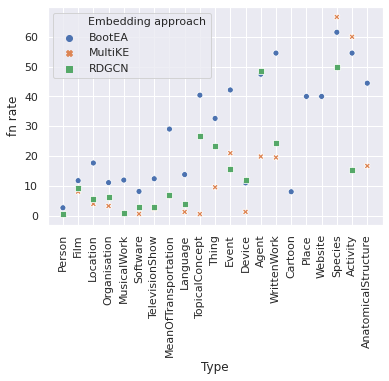

In [6]:
g = sns.scatterplot(x="Type",y="fn rate",hue="Embedding approach",style="Embedding approach",data=combined)
for label in g.get_xticklabels():
    label.set_rotation(90)

In [7]:
combined[combined["Type"] == "SportsSeason"]

,Type,occurence,fn,fp,avg node degree,fp rate,fn rate,rate of all,Embedding approach


In [8]:
bootea = combined[combined["Embedding approach"]=="BootEA"]
rdgcn = combined[combined["Embedding approach"]=="RDGCN"]
multike = combined[combined["Embedding approach"]=="MultiKE"]

In [9]:
stats.pearsonr(bootea[bootea["fn rate"].notna()]["fn rate"], bootea[bootea["fn rate"].notna()]["rate of all"])

(-0.4449863827186376, 0.04324566300377802)

In [10]:
stats.kendalltau(combined[combined["fn rate"].notna()]["fn rate"], combined[combined["fn rate"].notna()]["rate of all"])

KendalltauResult(correlation=-0.5120365429864253, pvalue=2.652018221382708e-08)

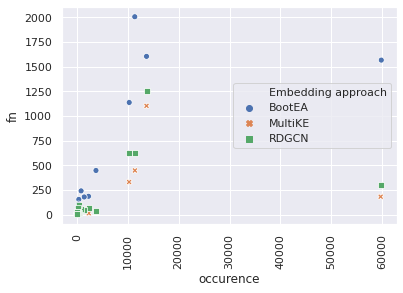

In [11]:
g = sns.scatterplot(x="occurence",y="fn", hue="Embedding approach", style="Embedding approach", data=combined)
for label in g.get_xticklabels():
    label.set_rotation(90)

<AxesSubplot:>

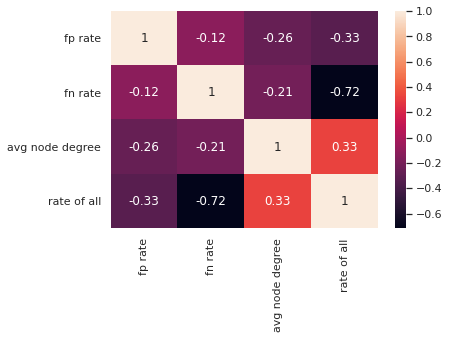

In [12]:
#corr = combined[["occurence","fn","fp","avg node degree"]].corr(method="spearman")
#mask = np.zeros_like(corr)
#mask[np.triu_indices_from(mask)] = True
#with sns.axes_style("white"):
#    sns.heatmap(corr, mask=mask, square=True, annot=True)
sns.heatmap(combined[["fp rate","fn rate","avg node degree","rate of all"]].corr(method="spearman"), annot=True)

In [16]:
kg1_ent_id_files, kg2_ent_id_files, pred_files = _get_files(embedding_approaches[0], dataset_name, "/home/dobraczka/Downloads/git/er-embedding-benchmark/data/")
df = create_typed_predictions(
            kg1_ent_id_files,
            kg2_ent_id_files,
            pred_files,
            type_files,
            "/home/dobraczka/Downloads/git/er-embedding-benchmark/data/OpenEA/typed_links/superclasses.json",
            1,
            False,
        )
entity_degrees = get_entity_node_degrees(f"/home/dobraczka/Downloads/git/er-embedding-benchmark/data/OpenEA/{dataset_name}")

In [28]:
ed = pd.Series(entity_degrees).to_frame(name="node degree")
ed.reset_index(inplace=True)
ed_left = ed.rename(columns={"index": "left_uri"})
ed_right = ed.rename(columns={"index": "right_uri"})
left = ed_left.merge(df, on="left_uri")[["left_uri","node degree"]]
right = ed_right.merge(df, on="right_uri")[["right_uri","node degree"]]
left = left.drop_duplicates()
right = right.drop_duplicates()
left = left.rename(columns={"node degree": "left node degree"})
right = right.rename(columns={"node degree": "right node degree"})

In [38]:
df_nd = df.merge(left, on="left_uri").merge(right, on="right_uri")
df_nd.loc[(df_nd["pred"] == 0) & (df_nd["val"] == 1), "match_type"] = "fn"
df_nd.loc[(df_nd["pred"] == 1) & (df_nd["val"] == 0), "match_type"] = "fp"
df_nd.loc[(df_nd["pred"] == 1) & (df_nd["val"] == 1), "match_type"] = "tp"
df_nd.loc[(df_nd["pred"] == 0) & (df_nd["val"] == 0), "match_type"] = "tn"

In [47]:
df_nd

,left_types,left_uri,pred,right_types,right_uri,val,left node degree,right node degree,match_type
0,http://dbpedia.org/ontology/Location,http://dbpedia.org/resource/Łódź,0,http://dbpedia.org/ontology/Location,http://de.dbpedia.org/resource/Łódź,1,21,19,fn
1,http://dbpedia.org/ontology/Location,http://dbpedia.org/resource/Łódź,0,http://dbpedia.org/ontology/Location,http://de.dbpedia.org/resource/Łódź,1,21,19,fn
2,http://dbpedia.org/ontology/Location,http://dbpedia.org/resource/Łódź,1,http://dbpedia.org/ontology/Location,http://de.dbpedia.org/resource/Łódź,1,21,19,tp
3,http://dbpedia.org/ontology/Location,http://dbpedia.org/resource/Łódź,0,http://dbpedia.org/ontology/Location,http://de.dbpedia.org/resource/Łódź,1,21,19,fn
4,http://dbpedia.org/ontology/Location,"http://dbpedia.org/resource/Pawnee_County,_Neb...",0,http://dbpedia.org/ontology/Location,http://de.dbpedia.org/resource/Łódź,0,11,19,tn
5,http://dbpedia.org/ontology/Organisation,http://dbpedia.org/resource/Racing_de_Santander,0,http://dbpedia.org/ontology/Location,http://de.dbpedia.org/resource/Łódź,0,68,19,tn
6,http://dbpedia.org/ontology/Person,http://dbpedia.org/resource/Freddy_Mombongo-Dues,0,http://dbpedia.org/ontology/Location,http://de.dbpedia.org/resource/Łódź,0,15,19,tn
7,http://dbpedia.org/ontology/Person,http://dbpedia.org/resource/Kazushi_Kimura,0,http://dbpedia.org/ontology/Location,http://de.dbpedia.org/resource/Łódź,0,10,19,tn
8,http://dbpedia.org/ontology/Person,http://dbpedia.org/resource/Silvio_Bankert,0,http://dbpedia.org/ontology/Location,http://de.dbpedia.org/resource/Łódź,0,11,19,tn
9,http://dbpedia.org/ontology/Person,http://dbpedia.org/resource/Joachim_Degener,0,http://dbpedia.org/ontology/Location,http://de.dbpedia.org/resource/Łódź,0,13,19,tn


In [58]:
df_nd = df_nd.rename(columns={"left node degree": "EN","right node degree":"DE"})
melted = df_nd.melt(id_vars=["left_uri","right_uri","left_types","right_types","match_type"], value_vars=["EN","DE"], var_name="node degree", value_name="degree")

In [56]:
melted = melted.rename(columns={"left node degree": "EN","right node degree":"DE"})

<AxesSubplot:xlabel='match_type', ylabel='degree'>

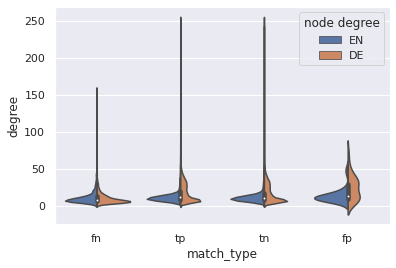

In [59]:
sns.violinplot(x="match_type",y="degree",hue="node degree",split=True,data=melted)